## Overview of the whole pipeline

Data Preprocessing:
- Acquisition
- Exploration and Cleaning
- Visualisation and Summary Statistics
- Feature Engineering
- Pre-processing for the specific computationals tools we have decided on

Other shit:

- Modelling and Evaluation
- Reporting, telling a story, connecting the dots


## Data Preprocessing

Acquire the Data
- Data folder. 
- Now we load files and folders.

In [9]:
import os
import pandas as pd
import numpy as np

data_dir = "Data/ml-latest-small"
movies_path = os.path.join(data_dir, "cleaned_movies.csv")
ratings_path = os.path.join(data_dir, "ratings.csv")
tags_path = os.path.join(data_dir, "cleaned_tags.csv")
links_path = os.path.join(data_dir, "cleaned_links.csv")

- Load the datasets into pandas DataFrames:

In [46]:
# Load the datasets into pandas DataFrames:
movies = pd.read_csv(movies_path)
ratings = pd.read_csv(ratings_path, usecols=['userId', 'movieId', 'rating']) # Discard timestamp column
tags = pd.read_csv(tags_path)
links = pd.read_csv(links_path)

In [11]:
## At a high level

# Movies 
# Print total number of movies
print("Total number of movies: ", len(movies))

# Print total number of ratings and users
#load ratings column 1 as numpy array
ratings_array = ratings.iloc[:, 1].values
#extract last userId to get total number of users
total_users = ratings['userId'].max()
print(total_users ," users gave ", str(len(ratings)) , " ratings.")

Total number of movies:  9742
610  users gave  100836  ratings.


- Visualise Movies CSV

In [12]:
print("Movies DataFrame:")
movies.head()


Movies DataFrame:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


- Visualise Links CSV

In [13]:
print("Links DataFrame:")
links.head()


Links DataFrame:


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


- Visualise Ratings CSV

In [14]:
print("Ratings DataFrame:")
ratings.head()


Ratings DataFrame:


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


- Visualise Tags CSV

In [15]:
print("Tags DataFrame:")
tags.head()

Tags DataFrame:


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


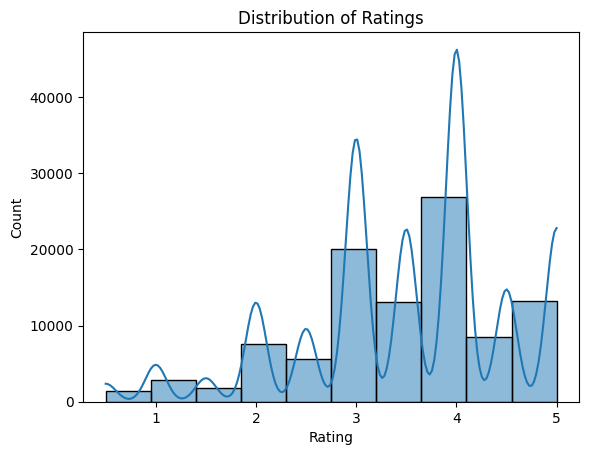

In [16]:
# Visualisations
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Ratings
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title("Distribution of Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

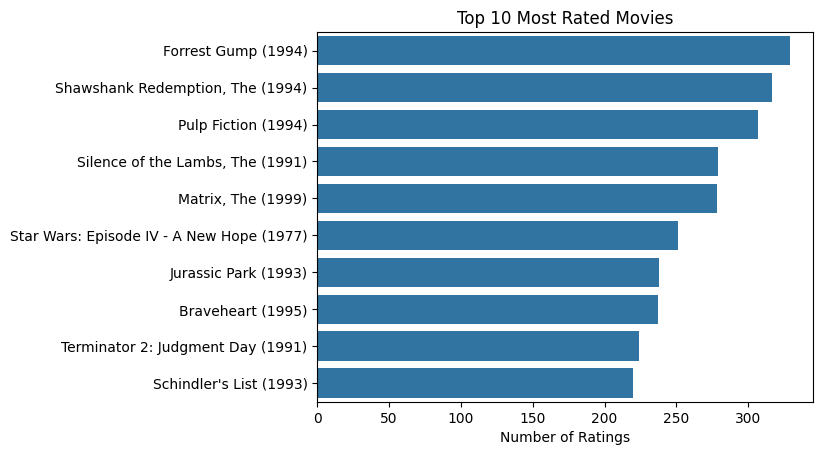

In [17]:
movie_ratings = ratings.groupby('movieId').agg(
    avg_rating=('rating', 'mean'),
    num_ratings=('rating', 'count')
).reset_index()

movie_ratings = movie_ratings.merge(movies, on='movieId')

top_movies = movie_ratings.sort_values('num_ratings', ascending=False).head(10)

sns.barplot(y='title', x='num_ratings', data=top_movies)
plt.title("Top 10 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.ylabel("")
plt.show()

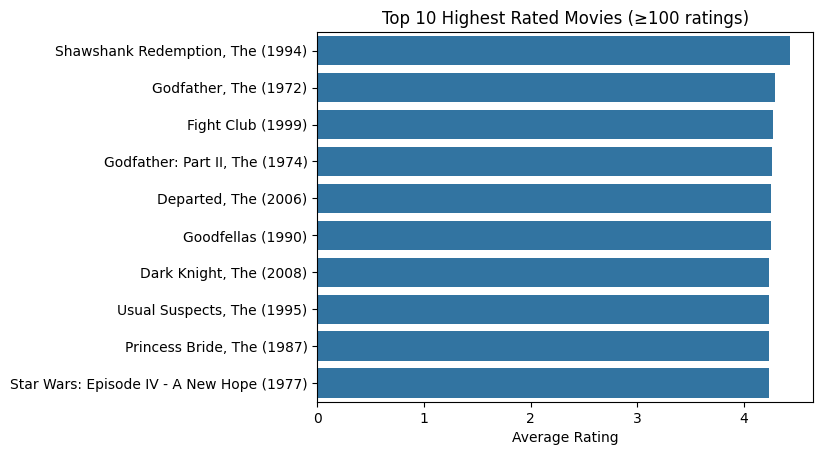

In [18]:
popular = movie_ratings[movie_ratings['num_ratings'] > 100]
top_rated = popular.sort_values('avg_rating', ascending=False).head(10)

sns.barplot(y='title', x='avg_rating', data=top_rated)
plt.title("Top 10 Highest Rated Movies (≥100 ratings)")
plt.xlabel("Average Rating")
plt.ylabel("")
plt.show()


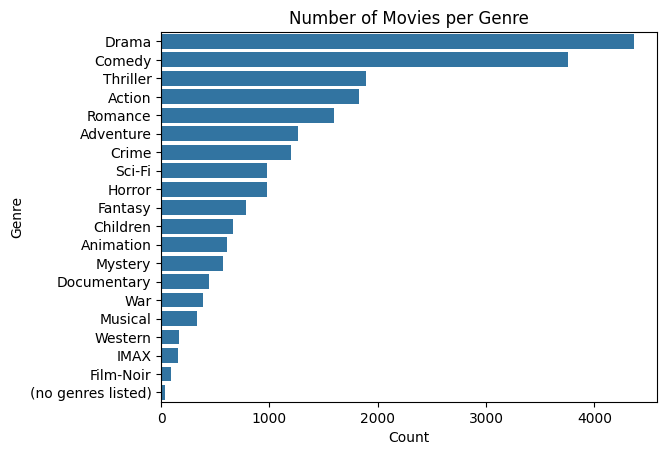

In [19]:
from collections import Counter

genre_counts = Counter(g for genres in movies['genres'] for g in genres.split('|'))
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count'])

sns.barplot(y='Genre', x='Count', data=genre_df.sort_values('Count', ascending=False))
plt.title("Number of Movies per Genre")
plt.show()


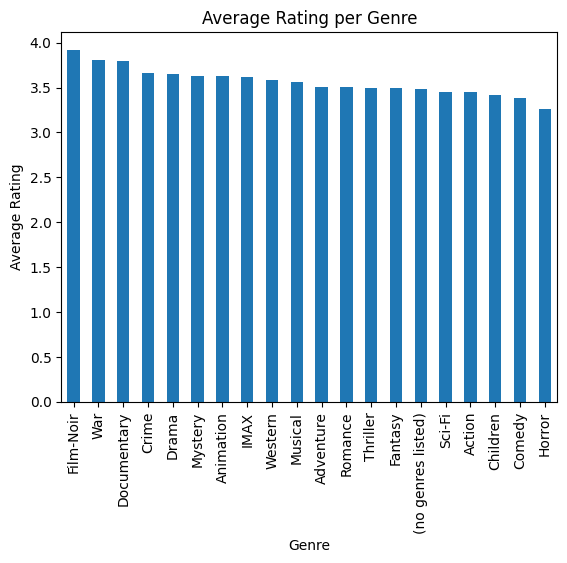

In [20]:
# Average rating per genre

movie_genres = movies.assign(Genre=movies['genres'].str.split('|')).explode('Genre')
genre_ratings = ratings.merge(movie_genres, on='movieId')
avg_genre_rating = genre_ratings.groupby('Genre')['rating'].mean().sort_values(ascending=False)

avg_genre_rating.plot(kind='bar')
plt.title("Average Rating per Genre")
plt.ylabel("Average Rating")
plt.show()

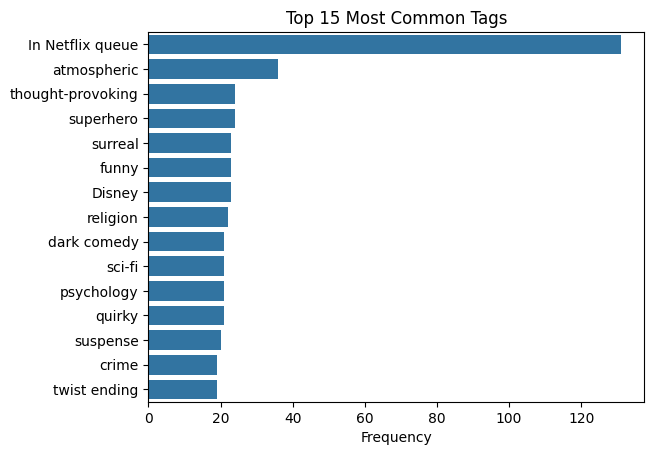

In [21]:
tag_counts = tags['tag'].value_counts().head(15)
sns.barplot(y=tag_counts.index, x=tag_counts.values)
plt.title("Top 15 Most Common Tags")
plt.xlabel("Frequency")
plt.ylabel("")
plt.show()

Show the sizes of each DataFrame:

In [22]:
# Show the sizes of each of the dataframe:
print(movies.info())
print(ratings.info())
print(tags.info())
print(links.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   movieId  100836 non-null  int64  
 2   rating   100836 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 2.3 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null 

# Apriori Algorithm

1. Generating the candidate 1-itemsets:

In [23]:
# 1. Calculate Total Users (Transactions)
total_users = ratings['userId'].nunique()

# Filter ratings first: Keep only rows where rating >= MIN_RATING
MIN_RATING = 4.0      # Only consider ratings >= 4.0
high_ratings = ratings[ratings['rating'] >= MIN_RATING]

# 2. Calculate Frequency (Raw Support) for each movie
# Count how many unique users rated each movie
movie_frequency = high_ratings.groupby('movieId')['userId'].nunique().rename('frequency')

# 3. Calculate Relative Support
# Support = (Number of users who rated the movie) / (Total number of users)
movie_support = (movie_frequency / total_users).rename('support')

# 4. Merge results with movie titles for readability
support_df = pd.merge(movies[['movieId', 'title']], movie_frequency, on='movieId', how='left')
support_df = pd.merge(support_df, movie_support, left_on='movieId', right_index=True, how='left')

# Fill NaNs for movies with 0 ratings
support_df['frequency'] = support_df['frequency'].fillna(0).astype(int)
support_df['support'] = support_df['support'].fillna(0.0)

# Sort by support descending to see top movies
support_df_sorted = support_df.sort_values(by='support', ascending=False)

# Display results
print(f"Total number of unique users: {total_users}\n")
print("Top 10 Movies by Support:")
print(support_df_sorted[['title', 'frequency', 'support']].head(10))

# Based on support of the 1-item groups
MIN_SUPPORT = 0.05 # Minimum support threshold (5% of total users)

# --- Frequent 1-Itemsets (L1) ---
# Filter support_df for movies meeting min_support
L1_df_sorted = support_df_sorted[support_df_sorted['support'] >= MIN_SUPPORT]
L1_movie_ids = L1_df_sorted['movieId'].tolist()

print(f"Found {len(L1_movie_ids)} frequent 1-itemsets (movies with support >= {MIN_SUPPORT*100}%).\n")

Total number of unique users: 610

Top 10 Movies by Support:
                                                  title  frequency   support
277                    Shawshank Redemption, The (1994)        274  0.449180
314                                 Forrest Gump (1994)        249  0.408197
257                                 Pulp Fiction (1994)        244  0.400000
510                    Silence of the Lambs, The (1991)        225  0.368852
1939                                 Matrix, The (1999)        222  0.363934
224           Star Wars: Episode IV - A New Hope (1977)        201  0.329508
2226                                  Fight Club (1999)        179  0.293443
461                             Schindler's List (1993)        175  0.286885
898   Star Wars: Episode V - The Empire Strikes Back...        168  0.275410
97                                    Braveheart (1995)        166  0.272131
Found 353 frequent 1-itemsets (movies with support >= 5.0%).



2. Generate candidate 2-Itemsets:

In [24]:
import itertools
from collections import defaultdict

# --- Generate Candidate 2-Itemsets (C2) ---
# Create all unique pairs from the frequent 1-itemsets
C2_candidates = list(itertools.combinations(L1_movie_ids, 2))
print(f"Generated {len(C2_candidates)} candidate 2-itemsets to check.\n")

# --- Count Support for Candidates ---
# Pre-process transactions for faster counting:
# Create a dictionary where keys are userIds and values are sets of movieIds they rated >= 4.0
user_transactions = high_ratings.groupby('userId')['movieId'].apply(set).to_dict()

# Initialize a counter for candidate pairs
candidate_counts = defaultdict(int)

# Count occurrences of each candidate pair in user transactions
for userId, rated_movies in user_transactions.items():
    for candidate in C2_candidates:
        # Check if both movies in the pair are in the user's rated movies
        if set(candidate).issubset(rated_movies):
            candidate_counts[candidate] += 1

# --- Filter to get Frequent 2-Itemsets (L2) ---
min_support_count = total_users * MIN_SUPPORT
L2_itemsets = []

for candidate, count in candidate_counts.items():
    if count >= min_support_count:
        support = count / total_users
        L2_itemsets.append({
            'movie_id_1': candidate[0],
            'movie_id_2': candidate[1],
            'frequency': count,
            'support': support
        })

# Convert to DataFrame for easy viewing and sorting
L2_df = pd.DataFrame(L2_itemsets)

# Merge with movie titles for readability
# Merge title for movie 1
L2_df = pd.merge(L2_df, movies[['movieId', 'title']], left_on='movie_id_1', right_on='movieId', how='left')
L2_df = L2_df.rename(columns={'title': 'movie_1_title'}).drop(columns='movieId')
# Merge title for movie 2
L2_df = pd.merge(L2_df, movies[['movieId', 'title']], left_on='movie_id_2', right_on='movieId', how='left')
L2_df = L2_df.rename(columns={'title': 'movie_2_title'}).drop(columns='movieId')

# Sort by support descending
L2_df_sorted = L2_df.sort_values(by='support', ascending=False)

print(f"Found {len(L2_df_sorted)} frequent 2-itemsets.\n")
print("Top 10 Frequent 2-Itemsets by Support:")
print(L2_df_sorted[['movie_1_title', 'movie_2_title', 'frequency', 'support']].head(10).to_string(index=False))

Generated 62128 candidate 2-itemsets to check.

Found 3703 frequent 2-itemsets.

Top 10 Frequent 2-Itemsets by Support:
                            movie_1_title                                         movie_2_title  frequency  support
         Shawshank Redemption, The (1994)                                   Forrest Gump (1994)        168 0.275410
         Shawshank Redemption, The (1994)                                   Pulp Fiction (1994)        158 0.259016
                      Pulp Fiction (1994)                      Silence of the Lambs, The (1991)        152 0.249180
Star Wars: Episode IV - A New Hope (1977) Star Wars: Episode V - The Empire Strikes Back (1980)        144 0.236066
         Shawshank Redemption, The (1994)                      Silence of the Lambs, The (1991)        140 0.229508
                      Forrest Gump (1994)                                   Pulp Fiction (1994)        136 0.222951
         Shawshank Redemption, The (1994)                           

3. Generate candidate 3-itemsets:

In [25]:
# --- Generate Candidate 3-Itemsets (C3) ---
L2_pairs = [sorted([item['movie_id_1'], item['movie_id_2']]) for item in L2_itemsets]
L2_pairs.sort()

# Convert to a set for fast lookup during pruning
L2_pairs_set = set(tuple(pair) for pair in L2_pairs)

C3_candidates = set()
for i in range(len(L2_pairs)):
    for j in range(i + 1, len(L2_pairs)):
        # Join step: If first items match ( [A, B] and [A, C] )
        if L2_pairs[i][0] == L2_pairs[j][0]:
            # Create candidate by union: {A, B, C}
            candidate = tuple(sorted(set(L2_pairs[i]) | set(L2_pairs[j])))

            # Prune step: Check if ALL size-2 subsets are frequent
            is_valid = True
            for subset in itertools.combinations(candidate, 2):
                if tuple(sorted(subset)) not in L2_pairs_set:
                    is_valid = False
                    break

            if is_valid:
                C3_candidates.add(candidate)
        else:
            # Since L2_pairs is sorted, if first items don't match anymore,
            # we can break the inner loop early for efficiency.
            break

# Convert back to list for the rest of your code
C3_candidates = list(C3_candidates)

print(f"Generated {len(C3_candidates)} candidate 3-itemsets to check.\n")

# --- Count Support for Candidates (C3) ---
# Initialize a counter for candidate triples
candidate_3_counts = defaultdict(int)

# Count occurrences of each candidate triple in user transactions
for userId, rated_movies in user_transactions.items():
    for candidate in C3_candidates:
        # Check if all 3 movies in the triple are in the user's rated movies
        if set(candidate).issubset(rated_movies):
            candidate_3_counts[candidate] += 1

# --- Filter to get Frequent 3-Itemsets (L3) ---
L3_itemsets = []

for candidate, count in candidate_3_counts.items():
    if count >= min_support_count:
        support = count / total_users
        L3_itemsets.append({
            'movie_id_1': candidate[0],
            'movie_id_2': candidate[1],
            'movie_id_3': candidate[2],
            'frequency': count,
            'support': support
        })

# Convert to DataFrame
L3_df = pd.DataFrame(L3_itemsets)

# Merge with movie titles for readability
# Merge title for movie 1
L3_df = pd.merge(L3_df, movies[['movieId', 'title']], left_on='movie_id_1', right_on='movieId', how='left')
L3_df = L3_df.rename(columns={'title': 'movie_1_title'}).drop(columns='movieId')
# Merge title for movie 2
L3_df = pd.merge(L3_df, movies[['movieId', 'title']], left_on='movie_id_2', right_on='movieId', how='left')
L3_df = L3_df.rename(columns={'title': 'movie_2_title'}).drop(columns='movieId')
# Merge title for movie 3
L3_df = pd.merge(L3_df, movies[['movieId', 'title']], left_on='movie_id_3', right_on='movieId', how='left')
L3_df = L3_df.rename(columns={'title': 'movie_3_title'}).drop(columns='movieId')

# Sort by support descending
L3_df_sorted = L3_df.sort_values(by='support', ascending=False)

print(f"Found {len(L3_df_sorted)} frequent 3-itemsets.\n")
print("Top 10 Frequent 3-Itemsets by Support:")
print(L3_df_sorted[['movie_1_title', 'movie_2_title', 'movie_3_title', 'frequency', 'support']].head(10).to_string(index=False))

Generated 47985 candidate 3-itemsets to check.

Found 10486 frequent 3-itemsets.

Top 10 Frequent 3-Itemsets by Support:
                                            movie_1_title                                         movie_2_title                                                                  movie_3_title  frequency  support
                                      Pulp Fiction (1994)                      Shawshank Redemption, The (1994)                                               Silence of the Lambs, The (1991)        108 0.177049
                Star Wars: Episode IV - A New Hope (1977) Star Wars: Episode V - The Empire Strikes Back (1980)                              Star Wars: Episode VI - Return of the Jedi (1983)        107 0.175410
                                      Pulp Fiction (1994)                      Shawshank Redemption, The (1994)                                                            Forrest Gump (1994)        106 0.173770
Lord of the Rings: The Fellowship o

4. Generate the Association Rules

In [26]:
# --- Configuration ---
MIN_CONFIDENCE = 0.5
rules = []

# --- Generate Rules from L2 (Pairs) ---
l1_support_dict = L1_df_sorted.set_index('movieId')['support'].to_dict()

for _, row in L2_df_sorted.iterrows():
    m1_id, m1_title = row['movie_id_1'], row['movie_1_title']
    m2_id, m2_title = row['movie_id_2'], row['movie_2_title']
    support_pair = row['support']

    # Rule 1: {Movie 1} -> {Movie 2}
    conf_1_to_2 = support_pair / l1_support_dict[m1_id]
    if conf_1_to_2 >= MIN_CONFIDENCE:
        lift = conf_1_to_2 / l1_support_dict[m2_id]
        rules.append({
            'antecedents': [m1_title],
            'consequents': [m2_title],
            'support': support_pair,
            'confidence': conf_1_to_2,
            'lift': lift,
            'type': 'L2'
        })

    # Rule 2: {Movie 2} -> {Movie 1}
    conf_2_to_1 = support_pair / l1_support_dict[m2_id]
    if conf_2_to_1 >= MIN_CONFIDENCE:
        lift = conf_2_to_1 / l1_support_dict[m1_id]
        rules.append({
            'antecedents': [m2_title],
            'consequents': [m1_title],
            'support': support_pair,
            'confidence': conf_2_to_1,
            'lift': lift,
            'type': 'L2'
        })

# --- Generate Rules from L3 (Triplets) ---
l2_support_dict = {}
for _, row in L2_df.iterrows():
    pair = tuple(sorted([row['movie_id_1'], row['movie_id_2']]))
    l2_support_dict[pair] = row['support']

for _, row in L3_df_sorted.iterrows():
    ids = [row['movie_id_1'], row['movie_id_2'], row['movie_id_3']]
    titles = [row['movie_1_title'], row['movie_2_title'], row['movie_3_title']]
    support_triplet = row['support']

    for i in range(3):
        ant_indices = [j for j in range(3) if j != i]
        ant_ids = sorted([ids[k] for k in ant_indices])
        ant_titles = [titles[k] for k in ant_indices]
        
        # Track consequent ID for lift calculation
        cons_id = ids[i]
        cons_title = [titles[i]]

        ant_support = l2_support_dict.get(tuple(ant_ids))
        if ant_support:
            confidence = support_triplet / ant_support
            if confidence >= MIN_CONFIDENCE:
                # Compute the lift
                lift = confidence / l1_support_dict[cons_id]
                rules.append({
                    'antecedents': ant_titles,
                    'consequents': cons_title,
                    'support': support_triplet,
                    'confidence': confidence,
                    'lift': lift,
                    'type': 'L3'
                })

# --- Display Results Sorted by Lift ---
rules_df = pd.DataFrame(rules)
# Sort by lift descending
rules_df_sorted_by_lift = rules_df.sort_values(by='lift', ascending=False)

print(f"Generated {len(rules_df)} rules with confidence >= {MIN_CONFIDENCE*100}%.\n")
print("Top 20 Rules by LIFT:")
print(rules_df_sorted_by_lift[['antecedents', 'consequents', 'support', 'confidence', 'lift', 'type']].head(20).to_string(index=False))

Generated 25226 rules with confidence >= 50.0%.

Top 20 Rules by LIFT:
                                                                                     antecedents                                                                                      consequents  support  confidence     lift type
                                                                               [Hot Fuzz (2007)]                                                                       [Shaun of the Dead (2004)] 0.052459    0.761905 8.769093   L2
                                                                      [Shaun of the Dead (2004)]                                                                                [Hot Fuzz (2007)] 0.052459    0.603774 8.769093   L2
[Harry Potter and the Sorcerer's Stone (a.k.a. Harry Potter and the Philosopher's Stone) (2001)]                                                 [Harry Potter and the Chamber of Secrets (2002)] 0.062295    0.655172 8.326149   L2
             

<!-- # K-Means Clustering -->

# K-Means Clustering

Create a movie corpus for each movie:

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Process Genres (MovieLens)
movies['genres_str'] = movies['genres'].str.replace('|', ' ')

# Process Tags (MovieLens)
tags['tag'] = tags['tag'].astype(str)
movie_tags = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()

# Initial Merge
metadata = pd.merge(movies, movie_tags, on='movieId', how='left')
metadata['tag'] = metadata['tag'].fillna('')

# --- 2. Load & Process TMDB Metadata ---
tmdb_path = r"Data/TMDB-API/tmdb_movie_details.csv"
try:
    tmdb_data = pd.read_csv(tmdb_path)
    
    # Ensure 'movieId' is the same type for merging (usually int)
    metadata['movieId'] = metadata['movieId'].astype(int)
    tmdb_data['movieId'] = tmdb_data['movieId'].astype(int)

    # Merge TMDB data into metadata
    # We only keep useful text columns for clustering
    metadata = pd.merge(metadata, tmdb_data[['movieId', 'overview', 'genres_tmdb', 'release_date']], on='movieId', how='left') # 

    # Fill NaNs in new columns
    metadata['overview'] = metadata['overview'].fillna('')
    metadata['genres_tmdb'] = metadata['genres_tmdb'].fillna('')

    print("TMDB metadata merged successfully.")

except FileNotFoundError:
    print(f"Error: File not found at {tmdb_path}. Please check the path.")
    # Create empty columns if file is missing so script doesn't crash later
    metadata['overview'] = ''
    metadata['genres_tmdb'] = ''

# --- 3. Create RICH Content String ---
# Combine all text sources. You can weigh them by repeating important ones if needed.
metadata['content'] = (
    metadata['genres_str'] + ' ' +
    metadata['tag'] + ' ' +
    metadata['genres_tmdb'] + ' ' +  # Adding TMDB genres too for completeness
    metadata['overview'] # + ' ' +  
    # metadata['release_date'].to_string() + ' ' +
    # metadata['original_language']
)

# Clean up extra spaces created by empty strings
metadata['content'] = metadata['content'].str.replace(r'\s+', ' ', regex=True).str.strip()
metadata['content'] = metadata['content'].fillna('')

print("\nExample extended content data:")
# print(metadata.head(10))

metadata['content'][0]

TMDB metadata merged successfully.

Example extended content data:


"Adventure Animation Children Comedy Fantasy pixar pixar fun Family,Comedy,Animation,Adventure Led by Woody, Andy's toys live happily in his room until Andy's birthday brings Buzz Lightyear onto the scene. Afraid of losing his place in Andy's heart, Woody plots against Buzz. But when circumstances separate Buzz and Woody from their owner, the duo eventually learns to put aside their differences."

In [32]:
# --- 2. TF-IDF Vectorization ---
# stop_words='english' removes common words like "the", "and", etc.
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(metadata['content'])

print(f"\nTF-IDF Matrix Shape: {tfidf_matrix.shape}")
# (Number of movies, Number of unique words in genres/tags)

# --- 3. K-Means Clustering ---
# Choosing k=20 as an arbitrary starting point for movie genres/types
NUM_CLUSTERS = 10
kmeans = KMeans(n_clusters=NUM_CLUSTERS, random_state=42)
kmeans.fit(tfidf_matrix)

# Add cluster labels back to the dataframe
metadata['cluster'] = kmeans.labels_

# --- 4. View Results ---
# Show 5 random movies from a few clusters to see if they make sense
for i in range(10): # Just show first 3 clusters as examples
    print(f"\n--- Cluster {i} ---")
    print(metadata[metadata['cluster'] == i]['title'].sample(5, replace=True).values)


TF-IDF Matrix Shape: (9742, 28557)

--- Cluster 0 ---
['Meet Me in St. Louis (1944)' 'Woman on Top (2000)'
 'Salmon Fishing in the Yemen (2011)' "Adam's Rib (1949)"
 'My Sassy Girl (Yeopgijeogin geunyeo) (2001)']

--- Cluster 1 ---
['The Grandmother (1970)' 'Ultimate Avengers 2 (2006)'
 'Ugly Duckling and Me!, The (2006)' 'Despicable Me 2 (2013)'
 'Winnie the Pooh and the Day of Concern (1972)']

--- Cluster 2 ---
['Searching for Sugar Man (2012)' 'Wild China (2008)' 'Bully (2011)'
 "Bruce Lee: A Warrior's Journey (2000)"
 'Encounters at the End of the World (2008)']

--- Cluster 3 ---
['Godzilla: Final Wars (Gojira: Fainaru uôzu) (2004)' 'Metropia (2009)'
 'Wasp Woman, The (1959)' 'Alien (1979)' 'Sunshine (2007)']

--- Cluster 4 ---
['Garage (2007)' 'Amen. (2002)' 'Rookie, The (2002)' 'Hoax, The (2007)'
 'Lions For Lambs (2007)']

--- Cluster 5 ---
['Warriors of Heaven and Earth (Tian di ying xiong) (2003)'
 'Last Legion, The (2007)' 'BMX Bandits (1983)' 'Wild America (1997)'
 'Sky H

In [33]:
import plotly.express as px
from sklearn.decomposition import PCA

metadata_aligned = metadata.reset_index(drop=True)

# 1. Dimensionality Reduction using PCA (Same as before)
# The components array is already 0-indexed.
pca = PCA(n_components=2)
components = pca.fit_transform(tfidf_matrix.toarray())

# Create a DataFrame for plotting
pca_df = pd.DataFrame(data=components, columns=['PC1', 'PC2'])

# 2. Add features from the ALIGNED metadata DataFrame
pca_df['cluster'] = metadata_aligned['cluster'].astype(str)
pca_df['title'] = metadata_aligned['title']        # CORRECTED: Takes title from the ALIGNED metadata
pca_df['genres'] = metadata_aligned['genres']      # CORRECTED: Takes genres from the ALIGNED metadata

# --- 3. Interactive Plotting with Plotly Express (Your original code, now working) ---

fig = px.scatter(
    pca_df,
    x='PC1',
    y='PC2',
    color='cluster',
    hover_data=['title', 'genres'], # These columns now exist in pca_df
    title=f'K-Means Clustering (k={NUM_CLUSTERS}) visualized with PCA',
    color_discrete_sequence=px.colors.qualitative.Alphabet,
    opacity=0.6
)

# Customize axis labels to show explained variance
pc1_variance = pca.explained_variance_ratio_[0] * 100
pc2_variance = pca.explained_variance_ratio_[1] * 100

fig.update_layout(
    xaxis_title=f"Principal Component 1 ({pc1_variance:.2f}%)",
    yaxis_title=f"Principal Component 2 ({pc2_variance:.2f}%)",
    height=700
)

fig.show()

ModuleNotFoundError: No module named 'plotly'

# Neural Network

Setup of data for pytorch:

In [34]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 1. Data Encoding (Mapping IDs to Continuous Integers) ---
# PyTorch Embedding layers require inputs to be integers from 0 to N-1.
# MovieLens IDs are non-continuous (e.g., jumping from 1 to 10), so we map them.

# Create mappings for Users
unique_user_ids = ratings['userId'].unique()
user_to_index = {old_id: new_id for new_id, old_id in enumerate(unique_user_ids)}
num_users = len(unique_user_ids)

# Create mappings for Movies
unique_movie_ids = ratings['movieId'].unique()
movie_to_index = {old_id: new_id for new_id, old_id in enumerate(unique_movie_ids)}
num_movies = len(unique_movie_ids)

# Apply mappings to the DataFrame
ratings['user_idx'] = ratings['userId'].map(user_to_index)
ratings['movie_idx'] = ratings['movieId'].map(movie_to_index)

print(f"Total Users: {num_users}")
print(f"Total Movies: {num_movies}")

# --- 2. Train / Validation / Test Split ---
# We use a standard 80% Train, 10% Validation, 10% Test split.

# First, split into Train (80%) and Temp (20%)
train_df, temp_df = train_test_split(ratings, test_size=0.2, random_state=42)

# Then, split Temp into Validation (50% of 20% = 10%) and Test (50% of 20% = 10%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

# --- 3. PyTorch Custom Dataset Class ---
class MovieLensDataset(Dataset):
    """
    Custom PyTorch Dataset for MovieLens data.
    Returns (user_idx, movie_idx, rating) for a given index.
    """
    def __init__(self, dataframe):
        # Convert relevant columns to tensors
        self.users = torch.tensor(dataframe['user_idx'].values, dtype=torch.long)
        self.movies = torch.tensor(dataframe['movie_idx'].values, dtype=torch.long)
        self.ratings = torch.tensor(dataframe['rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.ratings[idx]

# --- 4. Initialize DataLoaders ---
# DataLoaders handle batching and shuffling.

BATCH_SIZE = 64 # Adjust based on your GPU memory (32, 64, 128 are common)

# Create Dataset instances
train_dataset = MovieLensDataset(train_df)
val_dataset = MovieLensDataset(val_df)
test_dataset = MovieLensDataset(test_df)

# Create DataLoaders
# Shuffle=True for Train to prevent the model from learning order artifacts
# Shuffle=False for Val/Test is standard as order doesn't matter for evaluation
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("DataLoaders ready.")

# Example: Fetch one batch to see structure
sample_users, sample_movies, sample_ratings = next(iter(train_loader))
print(f"\nSample Batch - Users shape: {sample_users.shape}")
print(f"Sample Batch - Movies shape: {sample_movies.shape}")
print(f"Sample Batch - Ratings shape: {sample_ratings.shape}")

Using device: cuda
Total Users: 610
Total Movies: 9724
Train set size: 80668
Validation set size: 10084
Test set size: 10084
DataLoaders ready.

Sample Batch - Users shape: torch.Size([64])
Sample Batch - Movies shape: torch.Size([64])
Sample Batch - Ratings shape: torch.Size([64])


Define model, optimizer and loss function:

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch

# --- 1. Define the Neural Collaborative Filtering (NCF) Model ---
class NCFModel(nn.Module):
    def __init__(self, num_users, num_movies, embedding_dim=50):
        super(NCFModel, self).__init__()
        
        # 1. Embedding Layers
        # These layers act as lookup tables for the latent features of users and movies.
        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=embedding_dim)
        self.movie_embedding = nn.Embedding(num_embeddings=num_movies, embedding_dim=embedding_dim)
        
        # 2. Fully Connected (FFN) Layers
        # The input size to the FFN is the concatenated embeddings: embedding_dim * 2
        input_size = embedding_dim * 2
        
        self.fc_layers = nn.Sequential(
            # First hidden layer
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.3), # Dropout helps prevent overfitting
            
            # Second hidden layer
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            # Third hidden layer
            nn.Linear(64, 32),
            nn.ReLU()
        )
        
        # 3. Output Layer (Prediction)
        # Final layer predicts the single rating score.
        self.output_layer = nn.Linear(32, 1)

    def forward(self, user_indices, movie_indices):
        # Retrieve embeddings
        user_emb = self.user_embedding(user_indices)
        movie_emb = self.movie_embedding(movie_indices)
        
        # Concatenate embeddings to form the input vector for the FFN
        combined_input = torch.cat([user_emb, movie_emb], dim=1)
        
        # Pass through FFN layers
        x = self.fc_layers(combined_input)
        
        # Output the predicted rating
        prediction = self.output_layer(x)
        
        # Squeeze to remove the last dimension (e.g., [64, 1] -> [64])
        return prediction.squeeze()

# --- 2. Instantiate Model, Loss Function, and Optimizer ---

# Hyperparameters (You can tune these later)
LEARNING_RATE = 1e-4

# Instantiate the model and move it to the correct device (CPU/GPU)
model = NCFModel(num_users, num_movies).to(device)

# Define the Loss Function (Criterion)
# Since this is a regression task (predicting a score 1.0 to 5.0), 
# Mean Squared Error (MSE) is the standard choice.
criterion = nn.MSELoss()

# Define the Optimizer
# Adam is a common and effective choice for many deep learning tasks.
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

# --- 3. Optional: Print Model Summary ---
print("\nModel Architecture:")
print(model)


Model Architecture:
NCFModel(
  (user_embedding): Embedding(610, 50)
  (movie_embedding): Embedding(9724, 50)
  (fc_layers): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
  )
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)


In [41]:
import torch
import numpy as np

# --- Configuration ---
NUM_EPOCHS = 20
history = {
    'train_loss': [],
    'val_loss': [],
    'train_rmse': [],
    'val_rmse': []
}

# --- Helper Function for Evaluation ---
def evaluate_model(model, data_loader, criterion, device):
    """Calculates average loss and RMSE over a dataset."""
    model.eval() # Set the model to evaluation mode
    total_loss = 0.0
    total_samples = 0
    
    with torch.no_grad(): # Disable gradient calculations during evaluation
        for users, movies, ratings in data_loader:
            users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
            
            predictions = model(users, movies)
            loss = criterion(predictions, ratings)
            
            total_loss += loss.item() * len(ratings)
            total_samples += len(ratings)
            
    avg_loss = total_loss / total_samples
    # RMSE is the square root of the MSE (loss)
    avg_rmse = np.sqrt(avg_loss)
    
    return avg_loss, avg_rmse

# --- 1. Training Loop ---
print(f"\nStarting training for {NUM_EPOCHS} epochs...")

for epoch in range(1, NUM_EPOCHS + 1):
    model.train() # Set the model to training mode
    train_loss = 0.0
    
    for users, movies, ratings in train_loader:
        # Move data to the correct device
        users, movies, ratings = users.to(device), movies.to(device), ratings.to(device)
        
        # 1. Zero the gradients
        optimizer.zero_grad()
        
        # 2. Forward pass: compute predicted ratings
        predictions = model(users, movies)
        
        # 3. Compute loss
        loss = criterion(predictions, ratings)
        
        # 4. Backward pass: compute gradient of the loss
        loss.backward()
        
        # 5. Update model parameters
        optimizer.step()
        
        train_loss += loss.item() * len(ratings)

    # --- 2. Calculate Training Metrics ---
    # The training loss accumulated in the loop is the total loss for the epoch
    avg_train_loss = train_loss / len(train_df)
    train_rmse = np.sqrt(avg_train_loss)

    # --- 3. Run Validation Step ---
    val_loss, val_rmse = evaluate_model(model, val_loader, criterion, device)
    
    # --- 4. Store History ---
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(val_loss)
    history['train_rmse'].append(train_rmse)
    history['val_rmse'].append(val_rmse)
    
    # --- 5. Print Results ---
    print(
        f"Epoch {epoch}/{NUM_EPOCHS} | "
        f"Train MSE: {avg_train_loss:.4f}, Train RMSE: {train_rmse:.4f} | "
        f"Val MSE: {val_loss:.4f}, Val RMSE: {val_rmse:.4f}"
    )

print("\nTraining complete.")


Starting training for 20 epochs...
Epoch 1/20 | Train MSE: 2.5683, Train RMSE: 1.6026 | Val MSE: 1.0396, Val RMSE: 1.0196
Epoch 2/20 | Train MSE: 1.2180, Train RMSE: 1.1036 | Val MSE: 0.9820, Val RMSE: 0.9910
Epoch 3/20 | Train MSE: 1.1438, Train RMSE: 1.0695 | Val MSE: 0.9482, Val RMSE: 0.9738
Epoch 4/20 | Train MSE: 1.0920, Train RMSE: 1.0450 | Val MSE: 0.9342, Val RMSE: 0.9665
Epoch 5/20 | Train MSE: 1.0553, Train RMSE: 1.0273 | Val MSE: 0.9145, Val RMSE: 0.9563
Epoch 6/20 | Train MSE: 1.0164, Train RMSE: 1.0082 | Val MSE: 0.9044, Val RMSE: 0.9510
Epoch 7/20 | Train MSE: 0.9915, Train RMSE: 0.9958 | Val MSE: 0.8900, Val RMSE: 0.9434
Epoch 8/20 | Train MSE: 0.9680, Train RMSE: 0.9839 | Val MSE: 0.8876, Val RMSE: 0.9421
Epoch 9/20 | Train MSE: 0.9517, Train RMSE: 0.9756 | Val MSE: 0.8780, Val RMSE: 0.9370
Epoch 10/20 | Train MSE: 0.9355, Train RMSE: 0.9672 | Val MSE: 0.8723, Val RMSE: 0.9340
Epoch 11/20 | Train MSE: 0.9224, Train RMSE: 0.9604 | Val MSE: 0.8708, Val RMSE: 0.9332
Epoch

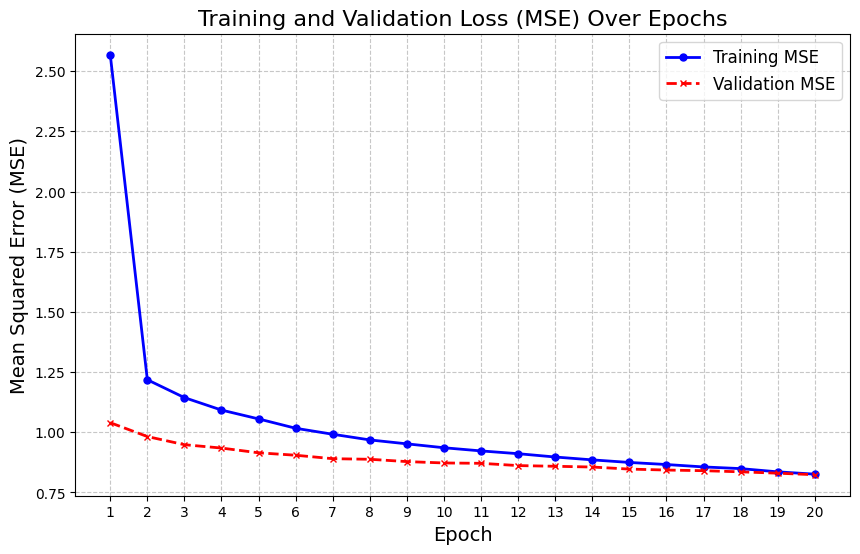

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Assume 'history' dictionary containing 'train_loss' and 'val_loss' 
# lists is available from the training loop execution.

# --- 1. Prepare Data ---
train_mse = history['train_loss']
val_mse = history['val_loss']
epochs = range(1, len(train_mse) + 1)

# --- 2. Create Plot ---
plt.figure(figsize=(10, 6))

# Plot training loss (MSE)
plt.plot(epochs, train_mse, 'b-o', label='Training MSE', linewidth=2, markersize=5)

# Plot validation loss (MSE)
plt.plot(epochs, val_mse, 'r--x', label='Validation MSE', linewidth=2, markersize=5)

# --- 3. Customize Plot ---
plt.title('Training and Validation Loss (MSE) Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Mean Squared Error (MSE)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(epochs)
plt.legend(fontsize=12)

plt.show()

In [47]:
import torch
import numpy as np
import pandas as pd # Needed for merging and viewing results

# --- Configuration ---
# Assume history, model, criterion, evaluate_model (from training_loop),
# test_loader, test_df, ratings, user_to_index, movie_to_index, and device
# are available from previous code executions.

# --- 1. Final Model Evaluation (Test Set) ---
def final_test_evaluation(model, test_loader, criterion, device):
    """Calculates final loss and RMSE on the unseen test set."""
    test_loss, test_rmse = evaluate_model(model, test_loader, criterion, device)
    print(f"\n--- Final Test Set Evaluation ---")
    print(f"Test MSE: {test_loss:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    return test_rmse

# --- 2. Recommendation Function ---
def recommend_for_user(target_user_id, model, movies_df, ratings_df, user_map, movie_map, top_n=5, device=device):
    """
    Predicts and recommends top N movies for a specific user ID.
    """
    # CRITICAL FIX: Ensure ratings_df is a pandas DataFrame before indexing.
    # If the user accidentally assigned a tensor to this variable name globally,
    # this will fix it locally within the function.
    if not isinstance(ratings_df, pd.DataFrame):
        raise TypeError("The ratings_df input must be a pandas DataFrame.")
        
    # 1. Convert external ID to internal index
    if target_user_id not in user_map:
        return f"Error: User ID {target_user_id} not found in the dataset."
        
    target_user_idx = user_map[target_user_id]
    
    # 2. Identify movies already rated by the user
    # This line triggered the error due to ratings_df being an unexpected type (likely torch.Tensor)
    rated_movie_ids = ratings_df[ratings_df['userId'] == target_user_id]['movieId'].unique()
    
    # 3. Get all movies and find unrated ones
    all_movies = movies_df.copy()
    unrated_movies = all_movies[~all_movies['movieId'].isin(rated_movie_ids)]
    
    # 4. Convert unrated movie IDs to internal indices
    unrated_movies['movie_idx'] = unrated_movies['movieId'].map(movie_map)
    unrated_movies = unrated_movies.dropna(subset=['movie_idx']) # Drop any movie not in the training set
    unrated_movies['movie_idx'] = unrated_movies['movie_idx'].astype(int)
    
    if unrated_movies.empty:
        return "No unrated movies available for recommendation."

    # 5. Prepare inputs for PyTorch
    num_unrated = len(unrated_movies)
    user_indices = torch.tensor([target_user_idx] * num_unrated, dtype=torch.long).to(device)
    movie_indices = torch.tensor(unrated_movies['movie_idx'].values, dtype=torch.long).to(device)
    
    # 6. Predict Scores (Inference)
    model.eval()
    with torch.no_grad():
        predictions = model(user_indices, movie_indices).cpu().numpy()
        
    # 7. Map predictions back to the DataFrame
    unrated_movies['predicted_rating'] = predictions
    
    # 8. Sort and Select Top N
    recommendations = unrated_movies.sort_values(by='predicted_rating', ascending=False).head(top_n)
    
    # 9. Format Output
    print(f"\n--- Recommendations for User {target_user_id} ---")
    print(f"User has rated {len(rated_movie_ids)} movies.")
    print("Top Recommended Movies:")
    
    return recommendations[['title', 'predicted_rating', 'genres']]

# --- 3. Example Execution ---
# We will select a random user from the test set for demonstration
# Note: You MUST ensure 'test_df' still has the 'userId' column before this line runs.
random_user_id = test_df['userId'].sample(1).iloc[0]

# Calculate and print final test metrics
test_rmse = final_test_evaluation(model, test_loader, criterion, device)

# Run recommendation engine
recommendations = recommend_for_user(
    target_user_id=random_user_id,
    model=model,
    movies_df=movies, # Assuming original movies df is available
    ratings_df=ratings, # Assuming original ratings df is available
    user_map=user_to_index,
    movie_map=movie_to_index,
    top_n=5,
    device=device
)
print(recommendations.to_string(index=False))


--- Final Test Set Evaluation ---
Test MSE: 0.8482
Test RMSE: 0.9210

--- Recommendations for User 552 ---
User has rated 188 movies.
Top Recommended Movies:
                                                                         title  predicted_rating                 genres
                                              Shawshank Redemption, The (1994)          4.192914            Crime|Drama
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)          3.989684       Action|Adventure
                                                             Casablanca (1942)          3.981454          Drama|Romance
                                              Silence of the Lambs, The (1991)          3.980416  Crime|Horror|Thriller
                                                         Reservoir Dogs (1992)          3.951111 Crime|Mystery|Thriller


/tmp/ipykernel_4177381/605544549.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unrated_movies['movie_idx'] = unrated_movies['movieId'].map(movie_map)
